#**TextVectorization() Layer**

#*How It Works*

The TextVectorization() layer in Keras automates / simplifies much of the textual pre-processing we might want to do. By default, it simply changes all text to lowercase, removes punctuation, and splits into 1-grams based on white space. Some integers are reserved in the resulting encoding. Most notably, the value of 1 is reserved for tokens that did not appear in the original corpus that was used to construct the integer encoding ([UNK]).

In [1]:
import tensorflow as tf
import string
import re
from tensorflow import keras

def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor) # We convert upper case characters to lowercase.
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "") # We find and remove punctuation.

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor) # By default the separator is white space.

text_vectorization = keras.layers.TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]

text_vectorization.adapt(dataset)
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 np.str_('erase'),
 np.str_('write'),
 np.str_('then'),
 np.str_('rewrite'),
 np.str_('poppy'),
 np.str_('i'),
 np.str_('blooms'),
 np.str_('and'),
 np.str_('again'),
 np.str_('a')]

Let's try using this layer to encode a sentence.

In [2]:
vocabulary = text_vectorization.get_vocabulary()

test_sentence = "I like to write practice sentences about a poppy that blooms again and again..."
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence.numpy())

inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

[ 7  1  1  3  1  1  1 11  6  1  8 10  9 10]
i [UNK] [UNK] write [UNK] [UNK] [UNK] a poppy [UNK] blooms again and again


#*Incorporating Into TF Dataset Pipeline*

There is a textfile equivalent function to what we'd seen previously for image data, called text_dataset_from_directory(). The folder structure works the same way as before and individual observations / documents should appear as separate .txt files in the folder.

Let's try this out using the IMDB Review dataset (an un-processed copy of it)...

In [3]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup
!cat aclImdb/train/pos/4077_10.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  26.0M      0  0:00:03  0:00:03 --:--:-- 26.0M
I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drin

We now have the root folder with test and train directories. Inside each of those directories we have neg and pos subdirectories, which in turn contain lots of .txt files (one per movie review).

In [4]:
!ls aclImdb/test/neg

0_2.txt      11405_3.txt  1562_4.txt  2969_2.txt  4376_1.txt  578_2.txt   7190_4.txt  8596_4.txt
10000_4.txt  11406_1.txt  1563_2.txt  2970_4.txt  4377_4.txt  5783_3.txt  7191_3.txt  8597_2.txt
10001_1.txt  11407_4.txt  156_3.txt   2971_4.txt  4378_4.txt  5784_3.txt  719_1.txt   8598_1.txt
10002_3.txt  11408_4.txt  1564_1.txt  2972_2.txt  4379_4.txt  5785_3.txt  7192_3.txt  8599_4.txt
10003_3.txt  11409_1.txt  1565_4.txt  297_2.txt   4380_3.txt  5786_3.txt  7193_1.txt  8600_3.txt
1000_3.txt   11410_1.txt  1566_4.txt  2973_1.txt  4381_3.txt  5787_3.txt  7194_2.txt  8601_2.txt
10004_2.txt  11411_2.txt  1567_1.txt  2974_1.txt  4382_3.txt  5788_4.txt  7195_1.txt  8602_1.txt
10005_2.txt  1141_1.txt   1568_4.txt  2975_2.txt  438_2.txt   5789_1.txt  7196_4.txt  8603_1.txt
10006_2.txt  11412_2.txt  1569_3.txt  2976_1.txt  4383_4.txt  5790_4.txt  7197_2.txt  8604_1.txt
10007_4.txt  11413_1.txt  1570_2.txt  2977_1.txt  4384_1.txt  5791_4.txt  7198_1.txt  860_4.txt
10008_4.txt  11414_4.txt  1571_

Here, we are going to start by creating a validation sample (so we have train, validation and test). To do this, we will siphon off 20% of the files in each category (pos and neg), and put them into a new folder (validation). We will first shuffle the files before selecting which ones to copy.

In [5]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

Now we can make our text datasets...

In [6]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Let's see what these datasets look like. Each batch of inputs is a set of 32 observations. Each observation is a string tensor. We have 32 labels for our 32 strings, which are 1-0 binary integer values.

In [7]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape) # We have 32 reviews per batch.
    print("inputs.dtype:", inputs.dtype) # They are strings.
    print("targets.shape:", targets.shape) # We have 32 labels per batch.
    print("targets.dtype:", targets.dtype) # They are integers.
    print("inputs[0]:", inputs[0]) # Here is the first example
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'Ayone who whines about how this movie was crap or that it had no plot must have been looking for "Jean de Florrette". HELLO! this film was made to be a random act of comedy and in no way involves a plot in any way shape or form. I would also like to remind these whiners that if you are going to flay the crap out of this film that they seem to be missing the point. This film is clearly made for people who don\'t appreciate the so called "american humour" which seems to me just a pile of smutty crap. The point is everyone has an opinion and you should be a bit more appreciative that some peoples sense of humour may not be in line with your own before shooting your mouth off.<br /><br />Thankyou', shape=(), dtype=string)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


Now we can apply our TextVectorization layer to the datasets. We are processing all the text ahead of time in the TF Dataset object, rather than processing it inside our network during the training process, because it will be faster.

In [8]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot", # This is requesting multihot encodings, so we are taking a bag of words approach.
    # output_mode="count", # Using this instead I can get term frequencies.
    # output_mode="tf_idf", # Using this gives me IDF weighted term counts
)

text_only_train_ds = train_ds.map(lambda x, y: x) # This lambda function will just return the text sample for each observation and drop the label.
text_vectorization.adapt(text_only_train_ds) # We can then apply our vectorizer to this corpus of data, and it will create the vocabulary, etc.

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), # Then we can apply the resulting vectorizer to the dataset, again via lambda function.
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Now each *new* dataset yields vectorized / processed versions of the observation's text, and the associated label. Our 1-gram multi-hot encoded representation is a matrix with 20k columns, 1's and 0's for word presence.

In [9]:
for x, y in train_ds:
  print(x[0])
  break

for x, y in binary_1gram_train_ds:
  print(x[0])
  break

tf.Tensor(b"Ned Kelly (Ledger), the infamous Australian outlaw and legend. Sort of like Robin Hood, with a mix of Billy the Kid, Australians love the legend of how he stood up against the English aristocratic oppression, and united the lower classes to change Australia forever. The fact that the lower classes of the time were around 70% immigrant criminals seems to be casually skimmed around by this film. Indeed, quite a few so called `facts' in this film are, on reflection, a tad dubious.<br /><br />I suppose the suspicions should have been aroused when, in the opening credits, it was claimed that this film is based upon the book, `Our Sunshine'. If ever a romanticized version of truth could be seen in a name for a book, there it was. This wasn't going to be a historical epic, but just an adaptation of one of many dubious legends of Ned Kelly, albeit a harsh and sporadically brutal version.<br /><br />Unfortunately, Ned Kelly is nothing more than an overblown Hallmark channel `real li

#*Train a Model*

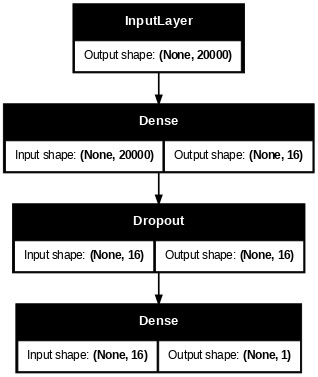

In [10]:
inputs = keras.Input(shape=(20000,)) # Here we have 20k columns as input for each observation.
x = keras.layers.Dense(16, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

keras.utils.plot_model(model,show_shapes=True,dpi=60)

And, now we can train and then test the model...

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]

history = model.fit(binary_1gram_train_ds.cache(),  # Note: using .cache will make it so file opening and data reading are up front, not during each epoch
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = keras.models.load_model("binary_1gram.keras")

print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7723 - loss: 0.4873 - val_accuracy: 0.8914 - val_loss: 0.2831
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8973 - loss: 0.2708 - val_accuracy: 0.8958 - val_loss: 0.2791
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9197 - loss: 0.2309 - val_accuracy: 0.8958 - val_loss: 0.2889
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9256 - loss: 0.2225 - val_accuracy: 0.8938 - val_loss: 0.3046
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9299 - loss: 0.2097 - val_accuracy: 0.8978 - val_loss: 0.3085
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9368 - loss: 0.2018 - val_accuracy: 0.8940 - val_loss: 0.3270
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9353 - loss: 0.1952 - val_accuracy: 0.8908 - val_loss: 0.3377
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9381 - loss: 0.1991 - val_accuracy: 

#*Bigrams, TF-IDF, etc.*

Let's try this again, but with a bit of sequence information. We'll incorporate bi-grams (note that we had done this before, manually).

In [12]:
text_vectorization_bigram = keras.layers.TextVectorization(
    max_tokens=20000, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting hot encodings; to get term counts we could request "count" as the output mode, and tf-idf using "tf-idf"
    ngrams=2 # We could also do (1,2) here for both unigrams AND bigrams
)

text_only_train_ds = train_ds.map(lambda x, y: x) # This lambda function will just return the text sample for each observation and drop the label.
text_vectorization_bigram.adapt(text_only_train_ds) # We can then apply our vectorizer to this corpus of data, and it will create the vocabulary, etc.

binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization_bigram(x), y), # Then we can apply the resulting vectorizer to the dataset, again via lambda function.
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization_bigram(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization_bigram(x), y),
    num_parallel_calls=4)

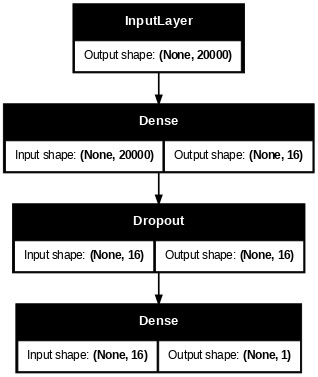

In [13]:
max_tokens=20000
hidden_dim=16

inputs = keras.Input(shape=(max_tokens,))
x = keras.layers.Dense(hidden_dim, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

keras.utils.plot_model(model,show_shapes=True,dpi=60)

We do 1.5-2% better in our test accuracy when we add in the bigrams. But, ultimately, the bigrams are only a crude representation of sequence information. We need to switch to proper sequence models to (potentially) do better.

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]

history = model.fit(binary_2gram_train_ds.cache(),  # Note: using .cache will make it so file opening and data reading are up front, not during each epoch
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = keras.models.load_model("binary_2gram.keras")

print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7737 - loss: 0.4755 - val_accuracy: 0.8974 - val_loss: 0.2658
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9064 - loss: 0.2568 - val_accuracy: 0.9056 - val_loss: 0.2665
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9288 - loss: 0.2061 - val_accuracy: 0.9042 - val_loss: 0.2843
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9419 - loss: 0.1849 - val_accuracy: 0.9006 - val_loss: 0.3012
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9481 - loss: 0.1688 - val_accuracy: 0.8992 - val_loss: 0.3166
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9507 - loss: 0.1776 - val_accuracy: 0.9038 - val_loss: 0.3315
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9562 - loss: 0.1553 - val_accuracy: 0.8992 - val_loss: 0.3554
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9562 - loss: 0.1641 - val_accuracy

#*Without TF Dataset Pipelines*

Let's say we just want to work with text data in memory... we can do that too... going back to our simple example... note that training will be slower if we do this because TextVectorization happens on the CPU. Typically approach is to use TF Datasets, pre-process the data for training, then take the final model and add the same pre-processing steps as layers at the end, to be able to pass raw text as input and get the associated predictions as output.

In [54]:
import numpy as np

dataset = [
    "I write erase rewrite",
    "Erase again and then",
    "A poppy blooms.",
]

dataset = np.stack(dataset).reshape(3,1)
dataset = tf.strings.as_string(dataset)

labels = np.array([1, 0, 1])

In [55]:
text_vectorization_bigram = keras.layers.TextVectorization(
    max_tokens=20000, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting hot encodings; to get term counts we could request "count" as the output mode, and tf-idf using "tf-idf"
    ngrams=2 # We could also do (1,2) here for both unigrams AND bigrams
)

text_vectorization_bigram.adapt(dataset)

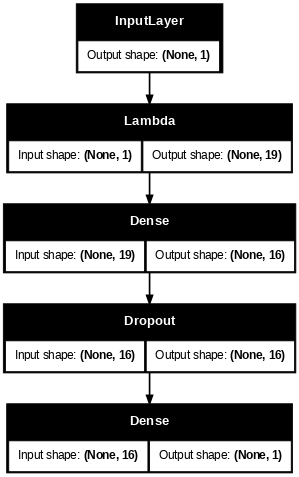

In [56]:
inputs = keras.Input(shape=[1,], dtype="string") # Be careful! You need to specify a string datatype here, or the model will produce errors when you go to fit.
processing = keras.layers.Lambda(lambda x: text_vectorization_bigram(x))(inputs)
x = keras.layers.Dense(hidden_dim, activation="relu")(processing)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

keras.utils.plot_model(model,show_shapes=True,dpi=60)

In [57]:
model.fit(dataset,labels,batch_size=1,epochs=10)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8333 - loss: 0.5638 
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8333 - loss: 0.6979
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8333 - loss: 0.5891
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8333 - loss: 0.7542
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4583 - loss: 0.9227    
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5417 - loss: 0.6341
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1667 - loss: 0.9192    
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8333 - loss: 0.5135
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7083 - loss: 0.5717
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4583 - loss: 0.6782    
